In [343]:
import pandas as pd
import numpy as np
import time
import os
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import *
import itertools
from sklearn import metrics 
mpl.rcParams['font.sans-serif'] = ['SimHei']

## 数据预处理

In [344]:
#进行粒度的划分
def Data_range(data,range_len):
    data.sort_values('时间')
    Time = data['时间']
    Values = data['容量']
    Values_new = []
    for i in range(0,len(data),range_len):
        values = round(np.mean(Values[i:i+range_len]),2)
        Values_new.append(values)
    return Values_new

In [349]:
#命中率数据
data_hit = pd.read_csv('hit_buquan_disk.csv')
Values_hit_new = Data_range(data_hit,3)
data_miss = pd.read_csv('miss_buquan_disk.csv')
Values_miss_new = Data_range(data_miss,3)
hit_rate = [b /(a+b) for a, b in zip(Values_miss_new,Values_hit_new)] 
seq = pd.Series(hit_rate)
#标准化处理
scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.values.reshape(-1,1))

In [372]:
#磁盘数据D
range_len = 36
data_d = pd.read_csv('d_buquan_disk.csv')
Values_dnew = Data_range(data_d,range_len)
seq = pd.Series(Values_dnew)
#标准化处理
scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.values.reshape(-1,1))

In [407]:
#磁盘数据C
range_len = 36
data_c = pd.read_csv('c_buquan_disk.csv')
Values_dnew = Data_range(data_c,range_len)
seq = pd.Series(Values_cnew)
#标准化处理
scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.values.reshape(-1,1))

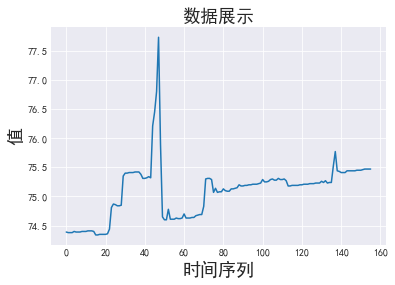

In [408]:
#数据展示
plt.figure(figsize=(6,4))
plt.title("数据展示", fontsize = 18)
plt.xlabel("时间序列", fontsize = 18)
plt.ylabel("值", fontsize = 18)
plt.plot(seq)
plt.show()

## 数据处理 
“input_seq_len + Output_seq_len”的总数的点将形成一个单一的训练样本，
输入(X)(编码器输入)是“input_seq”，我们的目标(Y)(解码器目标)是“output_seq”,
随机索引并创建这样的样本，以形成一批size= batch_size。

In [312]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

## 建立模型

In [313]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder过程
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder过程
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [325]:
def run_model(model,batches,epochs,batch_size):

    for _ in range(batches):
        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [368]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()
def Error(predict,true):
    mse = round(metrics.mean_squared_error(true, predict),4)
    rmse = round(np.sqrt(metrics.mean_squared_error(true, predict)),4)
    mae =  round(metrics.mean_absolute_error(true, predict),4)
    mape = round(np.mean(np.abs((true, predict) / np.array(true).reshape(1,len(true)))) * 100,4)
    print("误差MSE：",mse)
    print("误差RMSE：",rmse)
    print("误差MAE：",mae)
    print("误差MAPE：",mape)    
    plt.plot(predict,'y.',label="预测")
    plt.plot(true,'r.',label="真实")
    plt.xlabel(U'时间序号')
    plt.legend()
    plt.show()
    return mse,rmse,mae,mape

### 一层网络结构

In [419]:
x_train = X[:-20]#训练数据部分
y = X[-20:]#用来测试比较结果（处理后的数据20条包含5天的数据）
input_seq_len = 60#训练时候的输入长度
output_seq_len = 20#训练时候的输出长度
n_in_features = 1#特征，单序列为1
n_out_features = 1
batch_size = 10#每次放入的序列数量
epoch = 30#训练的迭代次数

训练过程

Train on 50 samples, validate on 6 samples
Epoch 1/30
50/50 [==============================] - 9s 174ms/step - loss: 0.2452 - val_loss: 0.1780
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.1564 - val_loss: 0.0863
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.0543 - val_loss: 0.0383
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.0285 - val_loss: 0.0071
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 8/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 9/30
50/50 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 10/30
50/50 [==============================] - 0s 4ms/step - loss: 

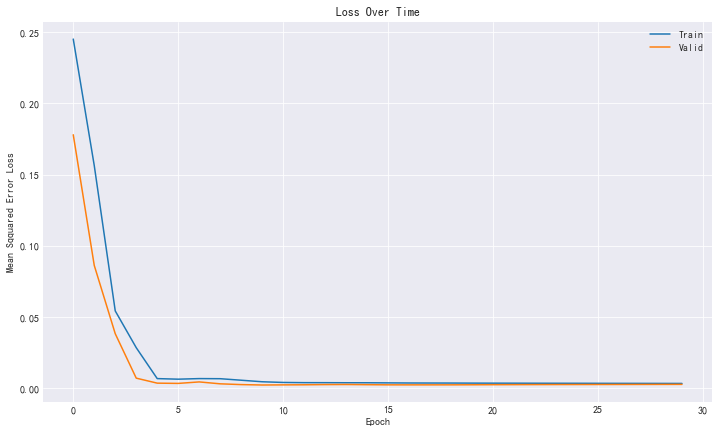

In [420]:
#15是中间隐藏层的个数
model_1 = create_model(layers=[60],bidirectional=False)
#训练过程展示
total_loss = []
total_val_loss = []
model_1.compile(Adam(), loss = 'mean_squared_error')
start_time = time.time()
run_model(model_1,batches=1, epochs=epoch, batch_size=batch_size)
end_time = time.time()
#训练时间
run_time = (end_time - start_time)/60
print("训练时间：",run_time)
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]
plot_loss(total_loss,total_val_loss)

预测过程

误差MSE： 0.0596
误差RMSE： 0.2441
误差MAE： 0.2312
误差MAPE： 99.8469


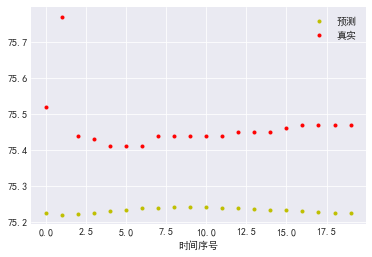

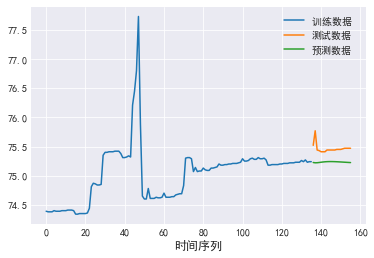

In [421]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = y[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))
#预测结果以及展示
pred1 = model_1.predict([input_seq_test,decoder_input_test])
pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))
output_seq_test1 = scaler.inverse_transform(output_seq_test)
output_seq_train1 = scaler.inverse_transform(x_train)

#计算误差画图
mse,rmse,mae,mape = Error(pred_values1,output_seq_test1)


l1, = plt.plot(range(len(output_seq_train1)), output_seq_train1, label = '训练数据 ')
l2, = plt.plot(range(len(x_train), len(y)+len(x_train)), output_seq_test1,  label = '测试数据')
l3, = plt.plot(range(len(x_train), len(y)+len(x_train)), pred_values1.reshape(-1), label = '预测数据')
plt.legend(handles = [l1, l2, l3])
plt.xlabel("时间序列", fontsize=12)
plt.show()


### 两层网络结构

In [250]:
x_train = X[:-20]
y = X[-20:]
input_seq_len = 60
output_seq_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10

训练过程

In [251]:
model_2 = create_model([60,60],bidirectional=False)
total_loss = []
total_val_loss = []
model_2.compile(Adam(), loss = 'mean_squared_error')
start_time = time.time()
run_model(model_2,batches=1, epochs=50, batch_size=batch_size,x_train)
end_time = time.time()
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]
plot_loss(total_loss,total_val_loss)
run_time = (end_time - start_time)/60
print("训练时间：",run_time)

预测过程

In [271]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = y[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

pred2 = model_2.predict([input_seq_test,decoder_input_test])
pred_values2 = scaler.inverse_transform(pred2.reshape(-1,1))
output_seq_test2 = scaler.inverse_transform(output_seq_test)

mse,rmse,mae,mape = Error(pred_values2,output_seq_test2)

plt.plot(pred_values2, label = "预测")
plt.plot(output_seq_test2, label = "真实")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("时间序列", fontsize=12)
plt.legend()
# plt.savefig('pred_.png')
plt.show()